In [1]:
import numpy
import pandas

import json

In [2]:
with open("helpers/config.json", "r") as fid:
    cfg = json.load(fid)

cfg

{'connectome': {'loading': {'conntility': '/scratch/datasets/microns_reimann/microns_mm3_connectome.h5',
   'args': ['condensed']},
  'subnetwork': {'base_volume': [],
   'simplices': [{'column': 'cell_type',
     'function': 'isin',
     'args': [['23P', '4P', '6CT', '5P_IT', '5P_PT', '5P_NP', '6IT']]},
    {'column': 'x_nm', 'function': 'gt', 'args': [700000]},
    {'column': 'x_nm', 'function': 'lt', 'args': [1200000]},
    {'column': 'z_nm', 'function': 'gt', 'args': [700000]},
    {'column': 'z_nm', 'function': 'lt', 'args': [1000000]}],
   'neurons': {'name': 'Inhibitory',
    'filters': [{'column': 'cell_type',
      'function': 'isin',
      'args': [['BC', 'MC', 'NGC']]}]}}},
 'analysis': {'simplex_dimension': 6,
  'use_weight': 0,
  'min_degrees': {'In': 200, 'Out': 200},
  'normalize_mat': 0,
  'clustering': {'use': 'source',
   'cluster_param': 2.2,
   'merge_smaller_than': 0.05,
   'normalize_cluster_paths': 'target',
   'normalize_cluster_disyn': 'target',
   'cutoff': {'

In [3]:
from helpers import network

M = network.load_network(cfg["connectome"]["loading"])
Msmpl = network.filter_network(M, cfg["connectome"]["subnetwork"]["simplices"])
name_nrn = cfg["connectome"]["subnetwork"]["neurons"]["name"]
Mnrn = network.filter_network(M, cfg["connectome"]["subnetwork"]["neurons"]["filters"])

In [ ]:
#### RANDOMIZATION. OPTIONAL
from randomization import create_dd_control_networks

if "randomization" in cfg["connectome"].keys():
    cols_coords = cfg["connectome"]["randomization"]["cols_coords"]
    model_name = cfg["connectome"]["randomization"]["model_name"] # Currently not used!
    Msmpl, Mnrn = create_dd_control_networks(M, Msmpl, Mnrn, cols_coords, model_name, cfg)

In [102]:
from helpers import analysis

dimensions = [cfg["analysis"]["simplex_dimension"]]
dimensions = [3, 4]

simplices, df_gids, df_idxs, ugids = analysis.get_simplex_dataframes(Msmpl, dimensions)
ugid = ugids[0]
df_gid = df_gids[0]
df_idx = df_idxs[0]
tgt_dim = dimensions[0]

 2023-11-08 18:46:03,378: COMPUTE list of simplices by dimension
100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.59s/it]


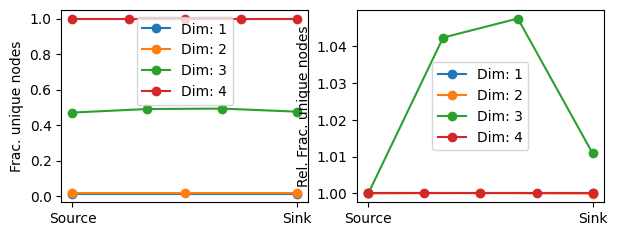

In [104]:
from helpers import plotting, analysis

fig = plotting.plot_simplex_divergences(analysis.get_divergences(simplices))

In [106]:
m_nrn_smpl, m_smpl_nrn = analysis.exc_inh_sparce_matrices(M, ugid, Mnrn.gids)
s_n_paths, n_s_paths = analysis.get_simplex_neuron_path_df(m_nrn_smpl, m_smpl_nrn, df_idx, name_nrn)

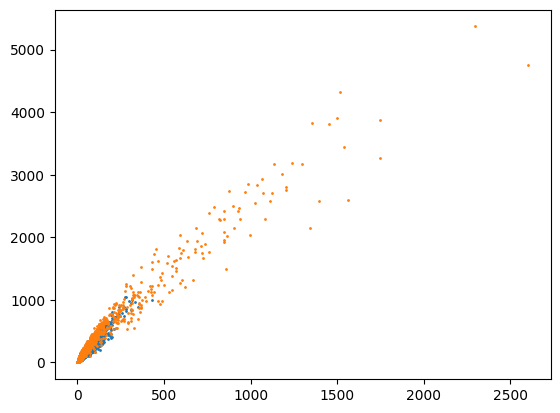

In [107]:
from matplotlib import pyplot as plt

nrn_degrees = analysis.simplex_specific_inout_degrees(s_n_paths, n_s_paths, name_nrn)

classic_indeg = numpy.array(m_smpl_nrn.sum(axis=0)).flatten()
classic_outdeg = numpy.array(m_nrn_smpl.sum(axis=1)).flatten()

plt.plot(classic_indeg, nrn_degrees["In"].reindex(range(len(classic_indeg))), '.', ms=2)
plt.plot(classic_outdeg, nrn_degrees["Out"].reindex(range(len(classic_indeg))), '.', ms=2)

[[1.         0.52804651]
 [0.52804651 1.        ]]


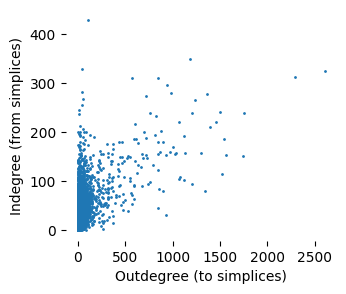

In [108]:
fig = plotting.plot_inout_degrees(m_nrn_smpl, m_smpl_nrn)

Text(0.5, 1.0, 'Inhibitory -> Simplex')

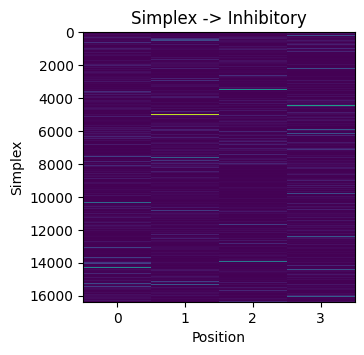

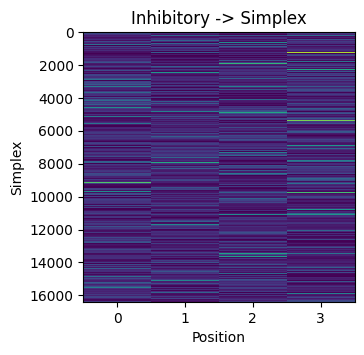

In [109]:
fig1 = plotting.plot_position_degrees(s_n_paths)
ax = plt.gcf().gca()
ax.set_title("Simplex -> {0}".format(name_nrn))

fig2 = plotting.plot_position_degrees(n_s_paths)
ax = plt.gcf().gca()
ax.set_title("{0} -> Simplex".format(name_nrn))

Text(0.5, 1.0, 'Inhibitory -> Simplex')

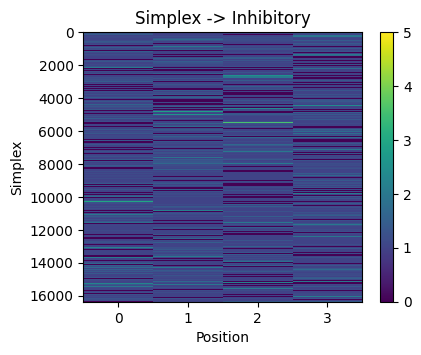

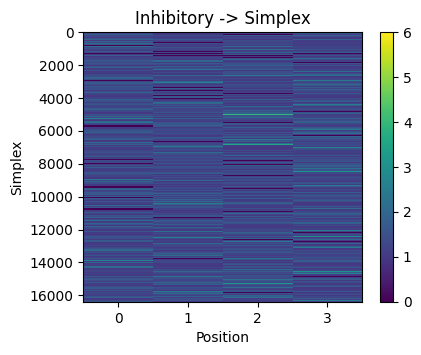

In [110]:
fig1 = plotting.plot_position_mean(s_n_paths)
ax = plt.gcf().gca()
ax.set_title("Simplex -> {0}".format(name_nrn))

fig2 = plotting.plot_position_mean(n_s_paths)
ax = plt.gcf().gca()
ax.set_title("{0} -> Simplex".format(name_nrn))

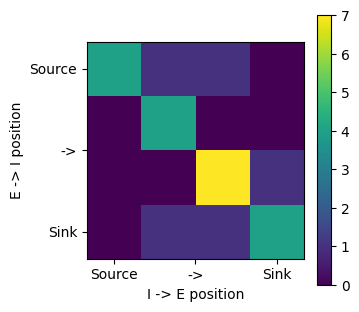

In [111]:
is_high_deg = numpy.all(nrn_degrees >= pandas.Series(cfg["analysis"]["min_degrees"]), axis=1)
rnd_smpl = numpy.random.choice(is_high_deg.index[is_high_deg])

I = analysis.get_disynaptic_path_sum(s_n_paths.reorder_levels([2, 1, 0])[rnd_smpl],
                                     n_s_paths.reorder_levels([2, 1, 0])[rnd_smpl],
                                     tgt_dim, use_weight=bool(cfg["analysis"]["use_weight"]))
fig = plotting.plot_disynaptic_path_sum(I)

100%|████████████████████████████████████████████████████████████████████████████████| 463/463 [00:00<00:00, 472.51it/s]


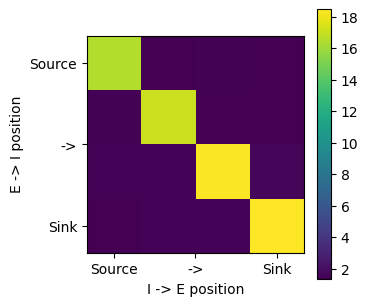

In [113]:
I = analysis.sum_disynaptic_path_sum(s_n_paths, n_s_paths, tgt_dim, name_nrn,
                                     min_degree=cfg["analysis"]["min_degrees"],
                                     use_weight=bool(cfg["analysis"]["use_weight"]))
fig = plotting.plot_disynaptic_path_sum(I)

In [114]:
tgt_shape = (len(df_gid), len(Mnrn))
disyn_nrn_mat = analysis.get_disynaptic_con_mat(s_n_paths, n_s_paths, name_nrn, tgt_shape,
                                                use_weight=bool(cfg["analysis"]["use_weight"]),
                                                normalize=bool(cfg["analysis"].get("normalize_mat", 0)))
disyn_ctrl_mat = analysis.get_disynaptic_con_mat(s_n_paths, n_s_paths, name_nrn, tgt_shape,
                                                 use_weight=bool(cfg["analysis"]["use_weight"]),
                                                 normalize=bool(cfg["analysis"].get("normalize_mat", 0)),
                                                 shuffle_cols=[name_nrn])

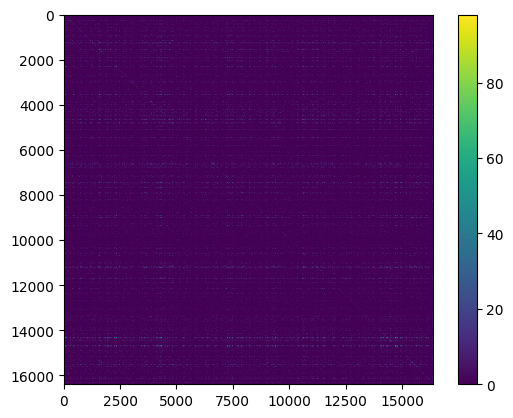

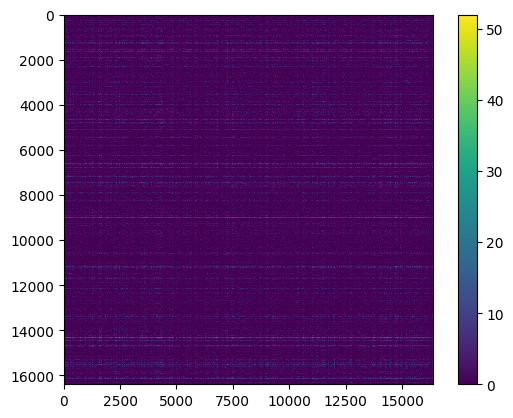

In [115]:
fig1 = plt.figure()
ax = fig1.gca()
plt.colorbar(ax.imshow((disyn_nrn_mat), interpolation="nearest"))

fig2 = plt.figure()
ax = fig2.gca()
plt.colorbar(ax.imshow((disyn_ctrl_mat), interpolation="nearest"))

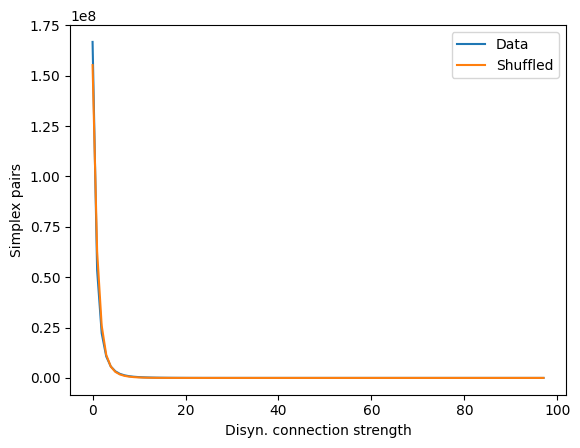

In [116]:
def compare_disyn_inhibition(m_data, m_ctrl):
    bins = numpy.linspace(0, m_data.max(), 101)
    H_data = numpy.histogram(m_data.flatten(), bins=bins)[0]
    H_ctrl = numpy.histogram(m_ctrl.flatten(), bins=bins)[0]

    plt.plot(bins[:-1], H_data, label="Data")
    plt.plot(bins[:-1], H_ctrl, label="Shuffled")

    plt.gca().set_xlabel("Disyn. connection strength")
    plt.gca().set_ylabel("Simplex pairs")
    plt.legend()

fig = plotting.compare_disyn_inhibition(disyn_nrn_mat, disyn_ctrl_mat)

In [117]:
print(numpy.var(disyn_ctrl_mat - disyn_ctrl_mat.transpose()) / numpy.var(disyn_ctrl_mat))
print(numpy.var(disyn_nrn_mat - disyn_nrn_mat.transpose()) / numpy.var(disyn_nrn_mat))

1.6072982348097893
1.3521818343472365


In [118]:
def simplex_overlap_in_positions(data_df, pos_idx, ugid):
    from scipy import sparse
    use_idx = data_df[pos_idx]
    shape = (len(data_df), len(ugid))

    mbr_mat = sparse.csr_matrix((numpy.ones(numpy.prod(use_idx.shape), dtype=int),
                                use_idx.values.flatten(),
                                numpy.arange(len(use_idx) + 1, dtype=int) * use_idx.shape[1]),
                                shape=shape)
    assert numpy.all(numpy.array(mbr_mat.sum(axis=1)).flatten() == use_idx.shape[1])
    return numpy.array((mbr_mat * mbr_mat.transpose()).todense())

_sz = tgt_dim + 1
_idx_low = numpy.arange(int(numpy.floor(_sz / 2)))
_idx_high = numpy.arange(int(numpy.ceil(_sz / 2)), _sz)

ol_src = simplex_overlap_in_positions(df_idx, _idx_low, ugid)
ol_tgt = simplex_overlap_in_positions(df_idx, _idx_high, ugid)

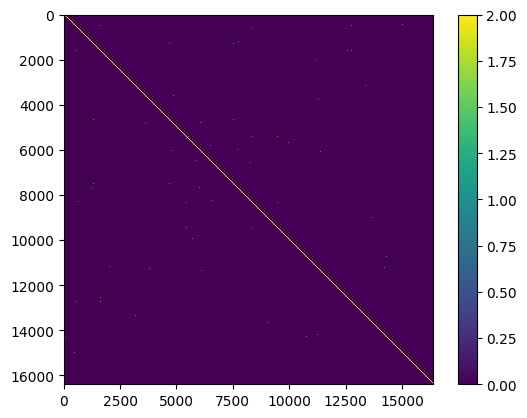

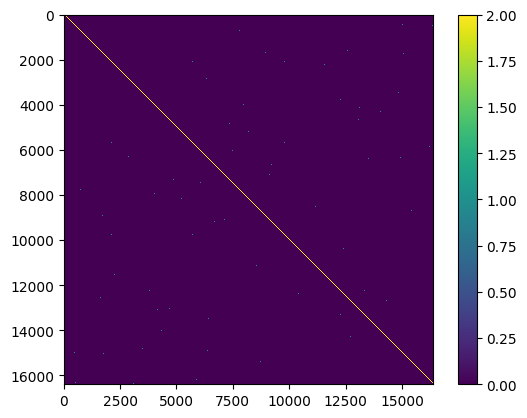

In [119]:
fig1 = plt.figure()
ax = fig1.gca()
plt.colorbar(ax.imshow(ol_src, interpolation="nearest"))

fig2 = plt.figure()
ax = fig2.gca()
plt.colorbar(ax.imshow(ol_tgt, interpolation="nearest"))

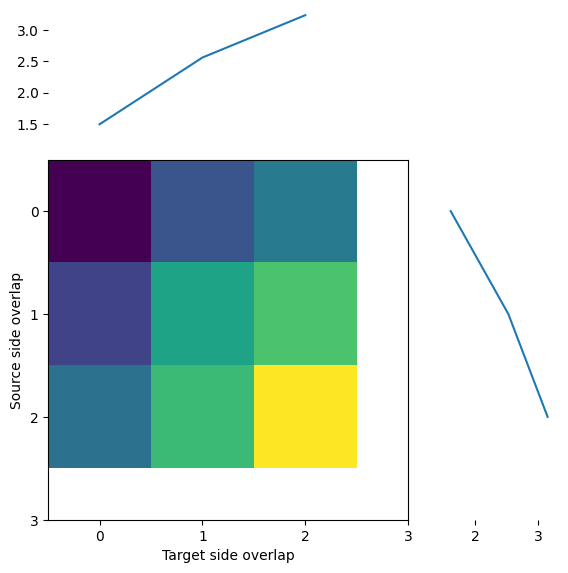

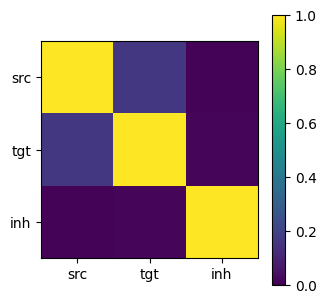

In [120]:
ol_disyn_mat, ol_disyn_cc, column_names = analysis.overlaps_vs_disyn(ol_src, ol_tgt, disyn_nrn_mat)
fig1 = plotting.plot_overlaps_vs_disyn(ol_disyn_mat)
fig2 = plotting.plot_overlap_vs_disyn_corr(ol_disyn_cc, column_names)

681
665


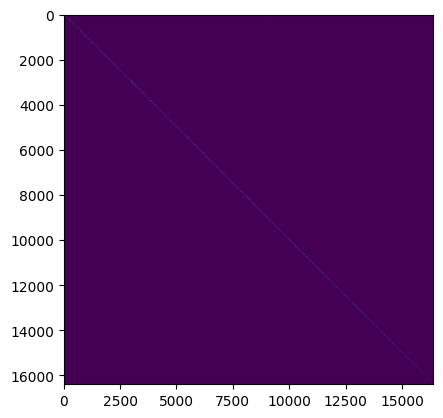

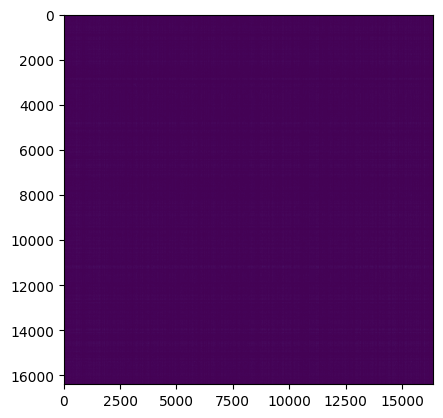

In [121]:
grp_df_full = analysis.simplex_clustering(ol_src, ol_tgt, cfg["analysis"]["clustering"]["cluster_param"])

if "merge_smaller_than" in cfg["analysis"]["clustering"]:
    grp_df = analysis.merge_small_clusters(grp_df_full, cfg["analysis"]["clustering"]["merge_smaller_than"])
else:
    grp_df = grp_df_full

lbls_src = grp_df["src_grp"]
lbls_tgt = grp_df["tgt_grp"]

idx = numpy.argsort(lbls_src)
plt.figure().gca().imshow(ol_src[numpy.ix_(idx, idx)])

plt.figure().gca().imshow(disyn_nrn_mat[numpy.ix_(idx, idx)])

In [122]:
clst_mat_smplx = analysis.simplex_cluster_connectivity(grp_df, cfg["analysis"]["clustering"]["normalize_cluster_paths"])

co = cfg["analysis"]["clustering"]["cutoff"]

if co["strategy"] == "percentile":
    cutoff = numpy.percentile(disyn_nrn_mat.flatten(), co["value"])
elif co["strategy"] == "percentile_control":
    cutoff = numpy.percentile(disyn_ctrl_mat.flatten(), co["value"])
elif co["strategy"] == "none":
    cutoff = None
elif co["strategy"] == "value":
    cutoff = co["value"]

clst_mat_disyn = analysis.simplex_cluster_disyn(disyn_nrn_mat, grp_df, cfg["analysis"]["clustering"]["normalize_cluster_disyn"], cutoff=cutoff)

ValueError: Length of values (212) does not match length of index (200)

In [ ]:
plt.colorbar(plt.imshow(clst_mat_smplx, aspect="auto", interpolation="nearest"))

In [ ]:
plt.colorbar(plt.imshow(clst_mat_disyn, aspect="auto", interpolation="nearest"))